(clas)=
# Clasificación de eventos
Uno de los objetivos principales de este trabajo es comparar algoritmos participantes en las LHCO 2020. Para ello, utilizamos como base algunos algoritmos sencillos ya implementados en librerías como `scikit-learn`{cite}`scikit-learn` y uno programado usando `tensorflow`{cite}`tensorflow2015-whitepaper`. 

En esta sección se observarán algunas de las característica de la clasificación con estos algoritmos. Los modelos que se utilizan en esta sección son:

```{table} Algoritmos utilizados para comparación
:name: clas-alg

|      Nombre                      | Implementación | Tipo                                             |
|:--------------------------------:|:--------------:|:------------------------------------------------:|
|Random Forest Classifier (RFC)    | `scikit-learn` | [Bosque aleatorio](alg-bosques)                  |
|Gradient Boosting Classifier (GBC)| `scikit-learn` | [Clasificador del gradiente del impulso](alg-gbc)|
|Quadratic Discriminant Analysis (QDA) | `scikit-learn` | [Análisis de discriminante cuadrático](alg-qda)  | 
|MLP Classifier                    | `scikit-learn` | [Red neuronal](alg-neural)                       |
|Tensorflow Classifier             | `tensorflow`   | [Red neuronal](alg-neural)                       |
| KMeans                           | `scikit-learn` | [K-means](alg-kmeans)                            |
```
explicados en la {numref}`alg`.

Para este análisis, se utilizó un subconjunto de 500,000 eventos del conjunto de datos R&D.
(clas-importancia)=
## Importancia de las características
Por la forma en la que clasifican, algunos modelos permiten conocer cuáles de las características de los eventos fueron las variables más relevantes para la clasificación. De los modelos en la {numref}`clas-alg`, RFC y GBC asignan puntajes a las variables de acuerdo a su importancia.

A continuación, realizaremos el entrenamiento de los modelos y la clasificación de los datos de prueba. Las celdas siguientes preparan los datos, entrenan los modelos y realizan la clasificación utilizando funciones de `benchtools`.

In [1]:
# Importamos las librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import argparse
import os.path

# De scikit-learn importamos herramientas
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# Y los clasificadores
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# Lo necesario para construir el modelo de tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

# Funciones de benchtools
from benchtools.src.plotools import bkg_sig_hist, bkg_sig_scatter, pred_test_hist
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from benchtools.scripts.run import TensorflowClassifier, training, evaluate
from benchtools.src.metrictools import rejection_plot, precision_recall_plot

In [2]:
# Datos a utilizar
path_data = "../../../datos/events_anomalydetection.h5"

In [ ]:
# Esta celda se corre una vez para pre-procesar los datos
# Una vez que el archivo existe no vuelve a correr
build_features(path_data=path_data, nbatch=11, outname='RnD-1100000', outdir='D:/', chunksize=100000)

Part 1/11


100%|██████████| 100000/100000 [21:45<00:00, 76.58it/s] 


Part 2/11


100%|██████████| 100000/100000 [19:54<00:00, 83.71it/s] 


Part 3/11


100%|██████████| 100000/100000 [20:11<00:00, 82.55it/s]


Part 4/11


100%|██████████| 100000/100000 [19:30<00:00, 85.46it/s]


Part 5/11


100%|██████████| 100000/100000 [19:55<00:00, 83.64it/s]


Part 6/11


100%|██████████| 100000/100000 [23:55<00:00, 69.68it/s] 


Part 7/11


100%|██████████| 100000/100000 [33:54<00:00, 49.14it/s] 


Part 8/11


 82%|████████▏ | 81539/100000 [20:44<06:41, 45.98it/s]   

In [4]:
# En esta celda preparamos los datos para utilizar los algoritmos
# Separamos los datos en conjuntos de entrenamiento y prueba
df_RnD = pd.read_csv('../../../datos/RnD-500000.csv')
X, y = separate_data(df_RnD, standarize=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training y 30% test

# Guardamos las columnas de masa
X_train_m = X_train.loc[:,['m_j1', 'm_j2', 'm_jj']].copy()
X_test_m = X_test.loc[:,['m_j1', 'm_j2', 'm_jj']].copy()

# Eliminamos las masas de los conjuntos de entrenamiento y prueba
X_train.drop(['m_j1', 'm_j2', 'm_jj'], axis=1, inplace=True)
X_test.drop(['m_j1', 'm_j2', 'm_jj'], axis=1, inplace=True)

In [5]:
# Listamos los clasificadores a utilizar
# En conjunto con el scaler
classifiers = [(MinMaxScaler(feature_range=(-1,1)), TensorflowClassifier(input_shape = [X_train.shape[1]])),
                (StandardScaler(), RandomForestClassifier(random_state=1)),
                (RobustScaler(), GradientBoostingClassifier(random_state=4)),
                (RobustScaler(), QuadraticDiscriminantAnalysis()), 
                (StandardScaler(), MLPClassifier(random_state=7)),
                (StandardScaler(), KMeans(n_clusters=2, random_state=15))
                ]

In [6]:
# Con esta función entrenamos los modelos
# Solo hace falta correrla una vez
#training(X_train, X_test, y_train, y_test, classifiers, '../../../datos', 'log')

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 14)               56        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               7680      
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2

100%|██████████| 6/6 [31:51<00:00, 318.51s/it]   


Models saved


In [7]:
# En esta celda cargamos los modelos entrenados
models = []

# Cargamos el algoritmo entrenado de tensorflow
tf_model = load_model(os.path.join('../../../datos','tf_model_{}.h5'.format('log')))
models.append(('TensorflowClassifier', tf_model))

# Cargamos los algoritmos entrenados de scikit-learn
with open(os.path.join('../../../datos',"sklearn_models_{}.pckl".format('log')), "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break

# Evaluamos
clfs = evaluate(X_test, y_test, models ,train=True)

100%|██████████| 6/6 [00:58<00:00,  9.83s/it]


De los modelos entrenados, se puede obtener la importancia de cada variable. Un gráfico de estos puntajes se observa en la {numref}`` y la {numref}`` para RFC y GBC, respectivamente.

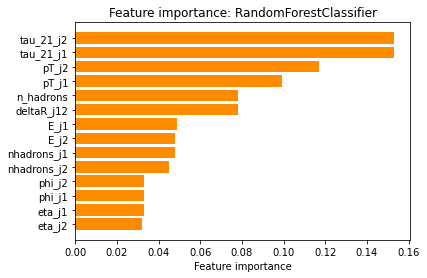

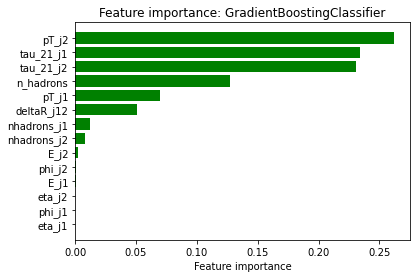

In [8]:
# En esta celda graficamos las características más importantes para los modelos

# Obtenemos las características más importantes
# models[x][y] : x = 1(random forest), 2(gradient boosting); y = 0(nombre del modelo), 1(modelo entrenado) 
fi_rf = models[1][1].steps[1][1].feature_importances_.tolist()
fi_gb = models[2][1].steps[1][1].feature_importances_.tolist()

# Redondeamos los puntajes
weights = [fi_rf, fi_gb]
weights = [[ round(elem, 3) for elem in weight ] for weight in weights]
# Obtenemos los nombres de los modelos
names_fi = [models[1][0], models[2][0]]
# Obtenemos los nombres de las características
features = X_train.columns.tolist()

# Juntamos los puntajes con las características en tuplas
importance = {}
ii = 0
for weight in weights:
    f_i = list(zip(features, weight))
    importance[names_fi[ii]] = f_i
    ii +=1

# Graficamos en un bucle 
colors=['darkorange', 'green']
ii = 0
for name, scores in importance.items():

    # Ordenamos de menor a mayor
    scores.sort(key=lambda x: x[1], reverse=False) 

    # Salvamos los nombres y su puntaje separados
    # y revertimos las tuplas para tener de mayor a menor puntaje 
    features = list(zip(*scores))[0]
    score = list(zip(*scores))[1]
    x_pos = np.arange(len(features)) 

    # Graficamos
    plt.barh(x_pos, score,align='center', color = colors[ii])
    plt.yticks(x_pos, features) 
    plt.xlabel('Feature importance')
    plt.title('Feature importance: {}'.format(name))
    plt.show()
    ii += 1

Notamos que las características más relevantes para ambos clasificadores son la variable $\tau_{21}$ y el $p_T$ de los jets. En general, son relevantes las características que presentan distribuciones diferentes para señal y fondo.
(clas-reconstruccion)=
## Reconstrucción de distribuciones
De la clasificación con los distintos modelos, se pueden reconstruir las variables para observar cómo están clasificando los algoritmos.

En la {numref}``observamos las variables más importante para clasificación de acuerdo a {numref}``.

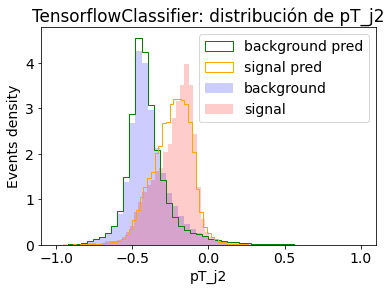

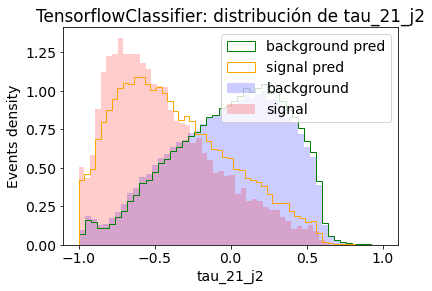

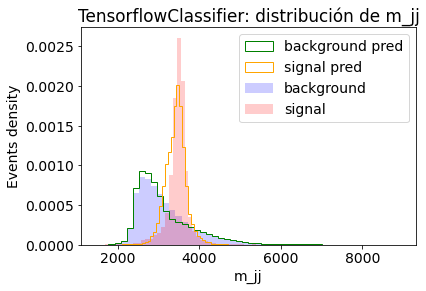

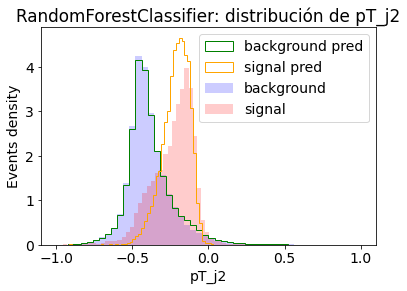

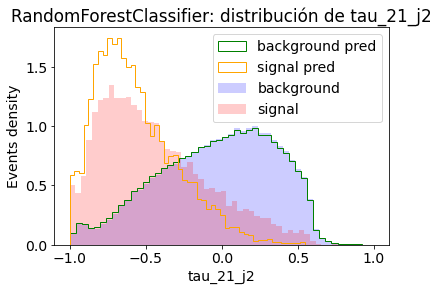

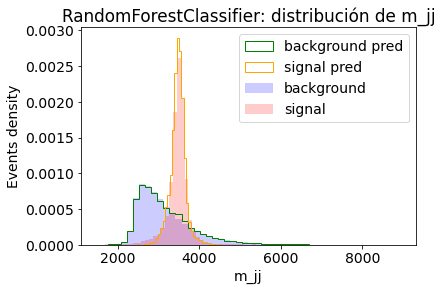

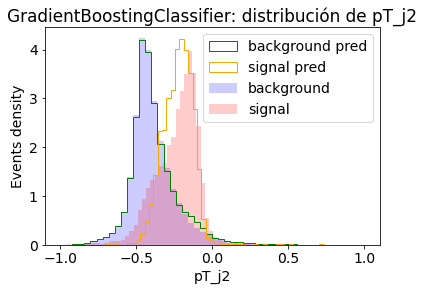

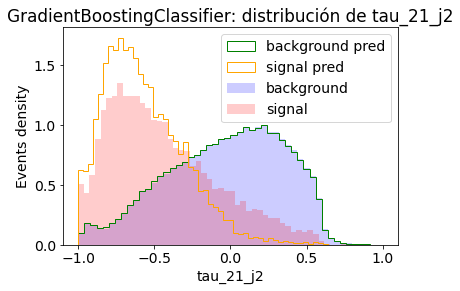

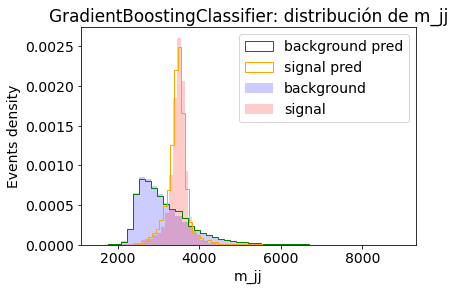

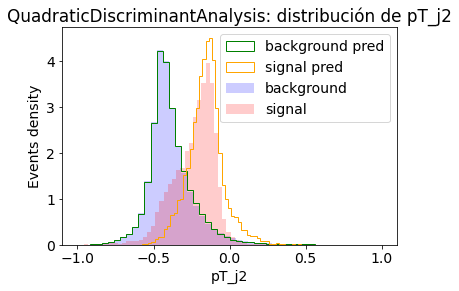

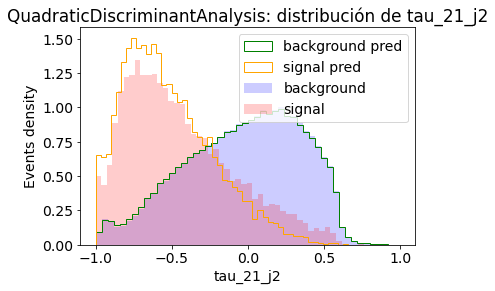

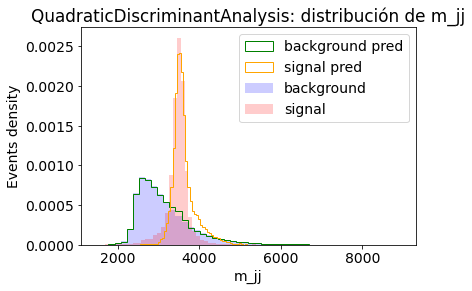

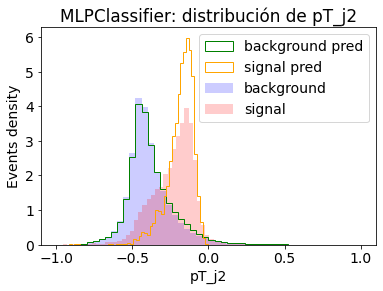

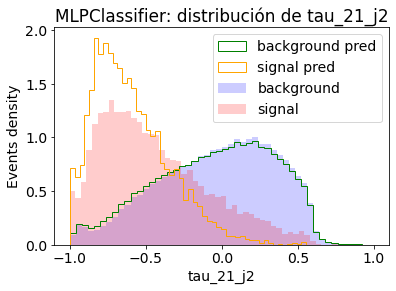

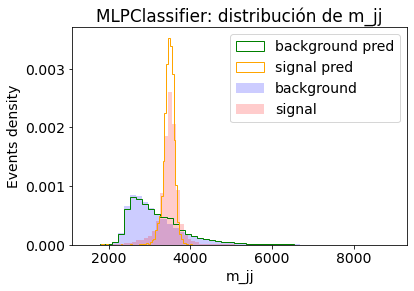

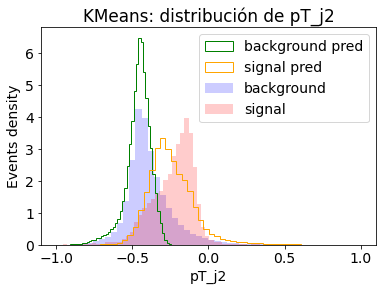

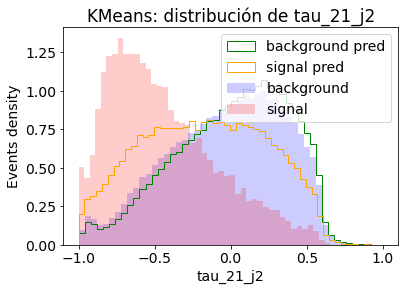

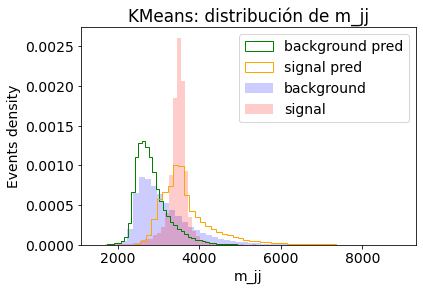

In [16]:
# En esta celda graficamos la masa invariante predicha
variables=['pT_j2', 'tau_21_j1', 'tau_21_j2', 'n_hadrons']
for model in clfs:
    for variable in variables:
        # Obtenemos predicciones como pandas Series
        pred = pd.Series(model.pred.flatten(), name='ypred')
        # Obtenemos las etiquetas como pandas Serie
        label = pd.Series(model.label, name='ytest').reset_index(drop=True)
        # Juntamos las masas, las predicciones y las etiquetas
        X_plot = pd.concat([X_test.reset_index(drop=True), X_test_m.reset_index(drop=True), pred, label], axis=1)
        # Graficamos
        pred_test_hist(X_plot, variable, ypred='ypred', ytest='ytest', n_bins=50, log=False)
        plt.title('{}: distribución de {}'.format(model.name, variable))
        plt.show()
    del X_plot, pred, label

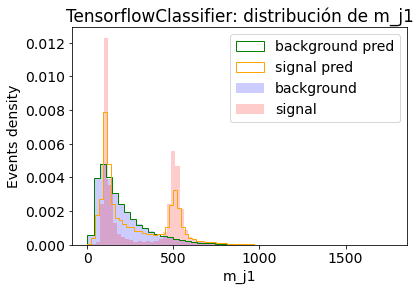

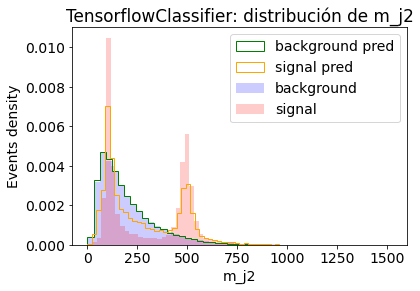

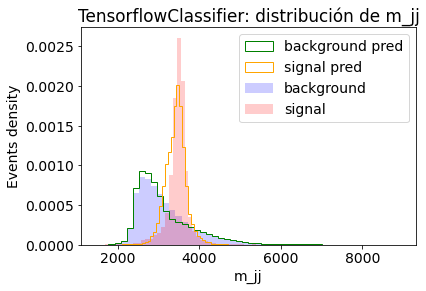

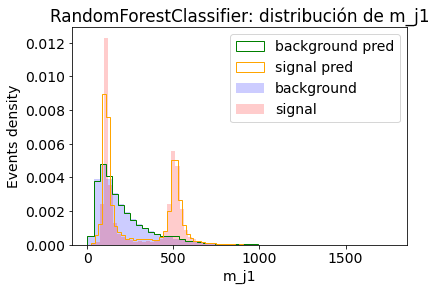

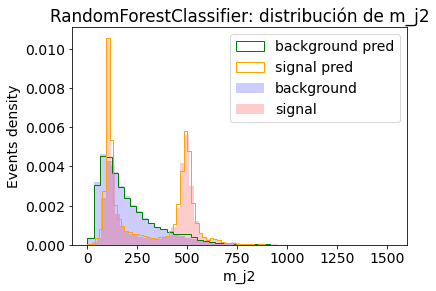

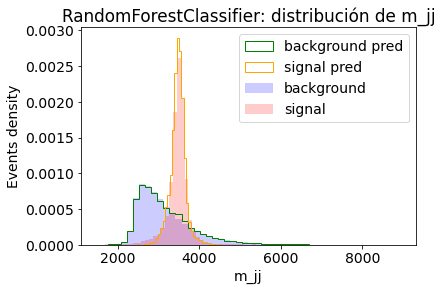

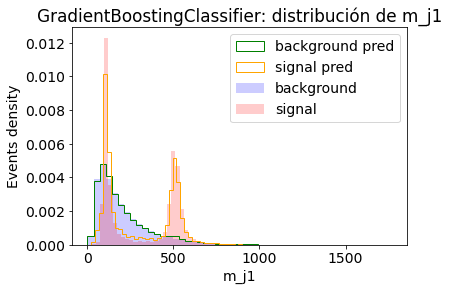

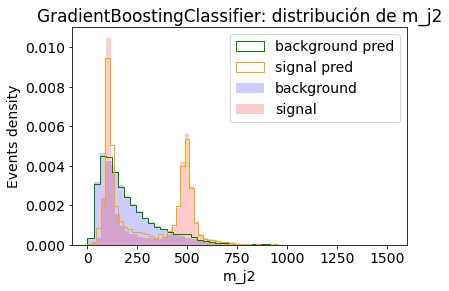

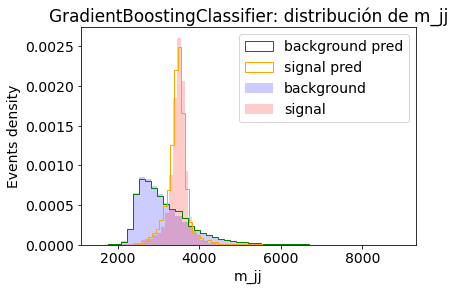

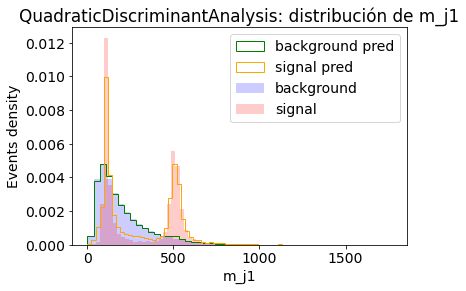

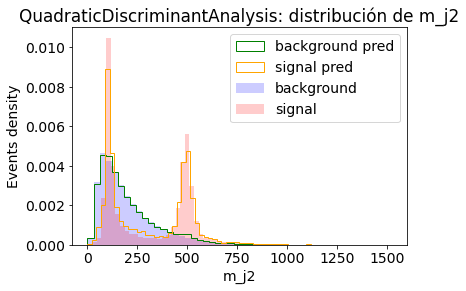

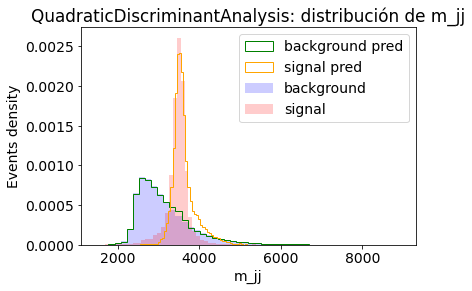

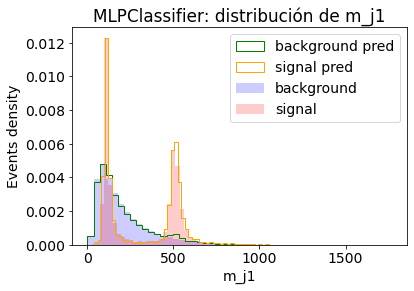

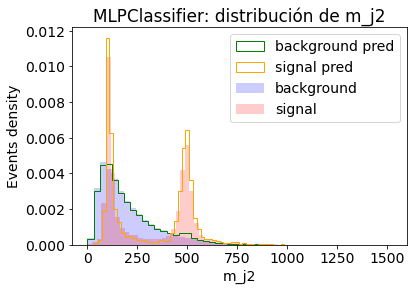

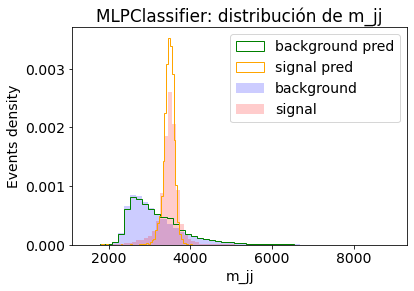

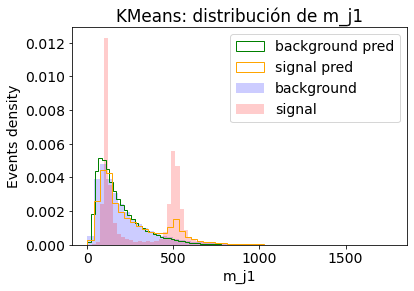

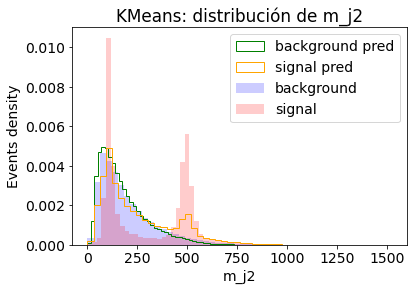

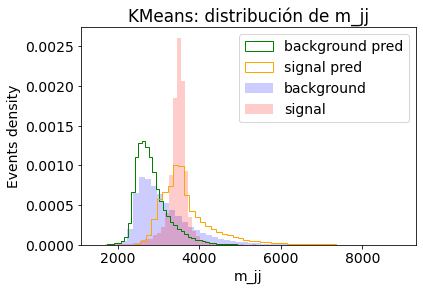

In [17]:
# En esta celda graficamos la masa invariante predicha
variables=['m_j1', 'm_j2', 'm_jj']
for model in clfs:
    for variable in variables:
        # Obtenemos predicciones como pandas Series
        pred = pd.Series(model.pred.flatten(), name='ypred')
        # Obtenemos las etiquetas como pandas Serie
        label = pd.Series(model.label, name='ytest').reset_index(drop=True)
        # Juntamos las masas, las predicciones y las etiquetas
        X_plot = pd.concat([X_test.reset_index(drop=True), X_test_m.reset_index(drop=True), pred, label], axis=1)
        # Graficamos
        pred_test_hist(X_plot, variable, ypred='ypred', ytest='ytest', n_bins=50, log=False)
        plt.title('{}: distribución de {}'.format(model.name, variable))
        plt.show()
    del X_plot, pred, label

In [10]:
# Obtenemos los datos de todos los clasificadores
names = [clf.name for clf in clfs]
scores = [clf.score for clf in clfs]
preds = [clf.pred for clf in clfs]      
labels = [clf.label.to_numpy() for clf in clfs]

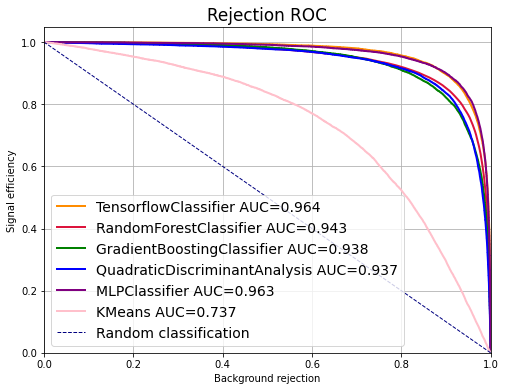

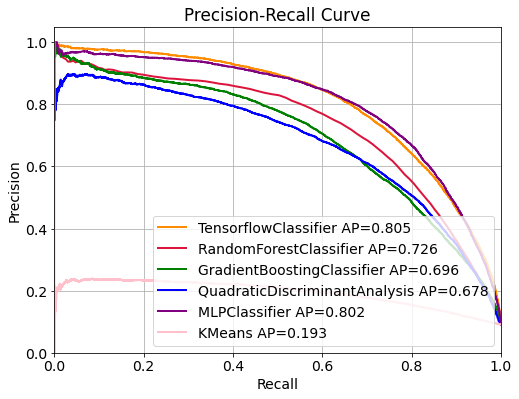

In [11]:
# Graficamos algunos plots
rejection_plot(names=names, labels=labels, probs=scores)
plt.show()
precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()